In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../sac_ae")

In [30]:
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
from sac_ae.env import make_envs
from sac_ae.model import make_model
from sac_ae.agent import make_agent
from memory import ReplayBufferStorage, make_replay_buffer, ReplayBufferDataset, ReplayBuffer, ReplayBufferStorageCost, ReplayBufferDatasetCost, ReplayBufferCost, load_episode
from utils.misc import eval_mode
from utils.argument import Arguments

In [4]:
def load_agent_and_args(path, device=torch.device('cpu')):
    args = Arguments(path + 'args.json')
    weights = torch.load(path + 'model/best_model.pt', map_location=device)

    if args.agent == 'sac_state':
        agent_obs_shape = weights['actor.encoder.projection.projection.0.weight'].shape[1:]
        args.agent_image_size = agent_obs_shape[0]
    else:
        agent_obs_shape = (3*args.frame_stack, args.agent_image_size, args.agent_image_size)
    action_shape = np.array([4])

    model = make_model(agent_obs_shape, action_shape, args, device)
    agent = make_agent(model, device, action_shape, args)
    agent.load_model_from_dict(weights)
    return agent, args

In [5]:
device = torch.device('cuda')
agent, args = load_agent_and_args('../../sac_ae/log/CustomFetchPushCostSmallDense-v0-09-25-14-15-im84-b256-s1-drq/')

In [6]:
env = make_envs(args, is_eval=True, use_state=args.agent == 'sac_state')

In [13]:
capacity = 100
replay_storage = ReplayBufferStorageCost(Path('buffer'), robot=args.robot_shape > 0, state=args.agent=="sac_state")
replay_buffer = None

In [14]:
episode, episode_reward, done, info = 0, 0, True, {}

for step in range(capacity+1):
        if done:
            if step > 0:
                if args.cost != 'no_cost':
                    replay_storage.add(obs, None, None, None, True)  # add the last observation for each episode
                else:
                    replay_storage.add(obs, None, None, True)

            obs = env.reset()
            done = False
            episode_reward = 0
            episode_step = 0
            episode += 1

        # sample action for data collection
        with eval_mode(agent):
            action = agent.sample_action(obs)

        next_obs, reward, done, info = env.step(action)

        # allow infinit bootstrap
        done_bool = 0 if episode_step + 1 == env._max_episode_steps else float(done)
        episode_reward += reward
        if args.cost != 'no_cost':
            replay_storage.add(obs, action, reward, info['cost'], done_bool)
        else:
            replay_storage.add(obs, action, reward, done_bool)

        obs = next_obs
        episode_step += 1

In [15]:
env_obs_shape = (3*args.frame_stack, args.env_image_size, args.env_image_size)
replay_buffer = make_replay_buffer(Path('buffer'),
                                    max_size=capacity,
                                    batch_size=100,
                                    num_workers=1,
                                    save_snapshot=False,
                                    nstep=1,
                                    discount=args.discount,
                                    obs_shape=env_obs_shape,
                                    device=device,
                                    image_size=args.agent_image_size,
                                    image_pad=args.image_pad,
                                    robot=args.robot_shape > 0,
                                    save_cost=args.cost != 'no_cost')

In [87]:
obs, action, reward, cost, next_obs, not_done, obs_aug, next_obs_aug = replay_buffer.sample_drq()

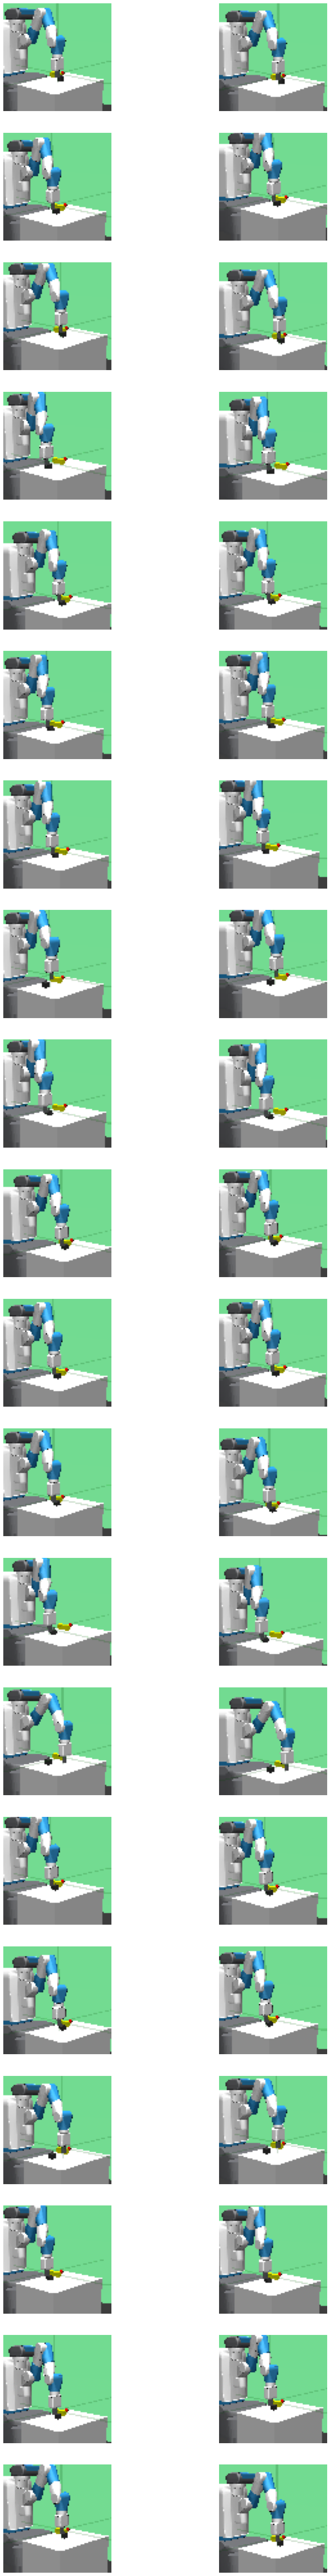

In [84]:
num_images = 20
fig = plt.figure(figsize=(15, num_images*5))
for i in range(num_images):
    ax = plt.subplot(num_images, 2, 2*i + 1)
    plt.axis('off')
    plt.imshow(obs['image'][i, :3].cpu().numpy().transpose(1, 2, 0) / 255)
    ax = plt.subplot(num_images, 2, 2*i + 2)
    plt.axis('off')
    plt.imshow(obs_aug['image'][i, :3].cpu().numpy().transpose(1, 2, 0) / 255)

In [88]:
import torch.nn as nn
import kornia

In [89]:
aug_trans = nn.Sequential(
    nn.ReplicationPad2d(args.image_pad),
    kornia.augmentation.RandomCrop((env_obs_shape[-1], env_obs_shape[-1])))

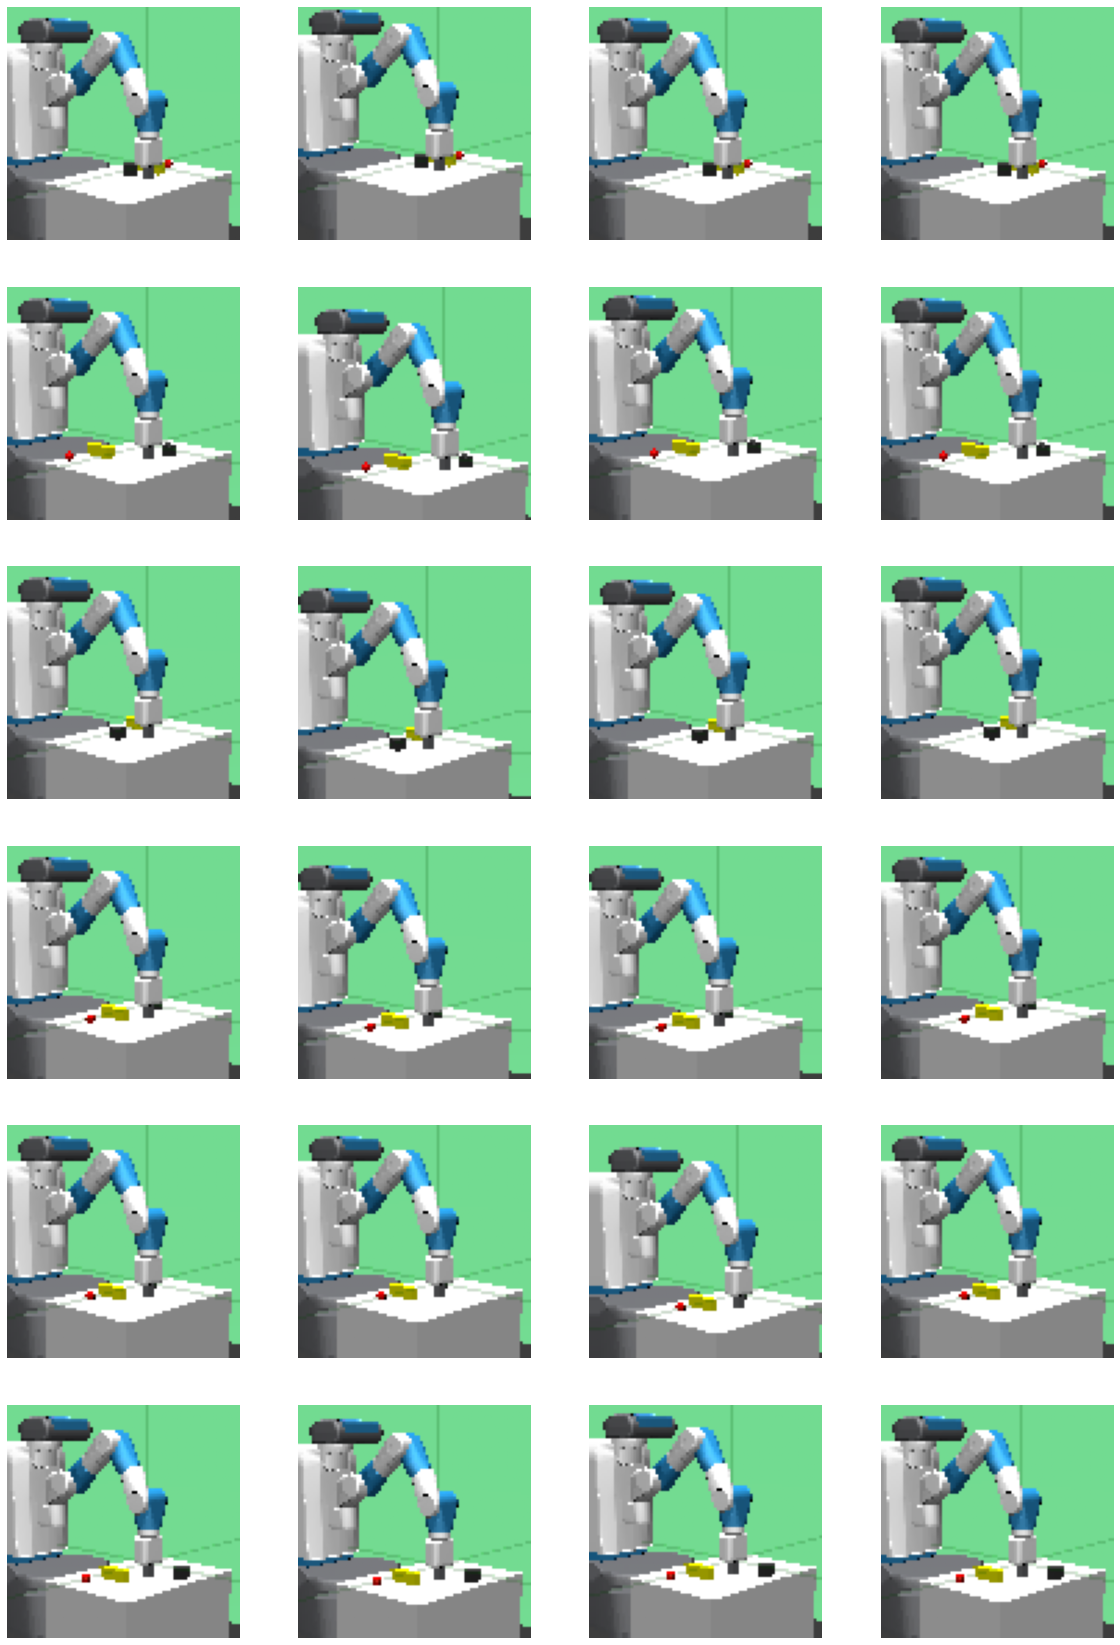

In [97]:
num_images = 6
num_augmentations = 4
fig = plt.figure(figsize=(num_augmentations*5, num_images*5))
for k in range(num_images):
    obs = env.reset()
    for i in range(num_augmentations):
        ax = plt.subplot(num_images, num_augmentations, num_augmentations * k + i + 1)
        plt.axis('off')
        img = torch.FloatTensor(obs['image'])
        if i % 3 != 0:
            img = aug_trans(img)[0]
        img = img[:3].numpy().transpose(1, 2, 0) / 255
        plt.imshow(img)

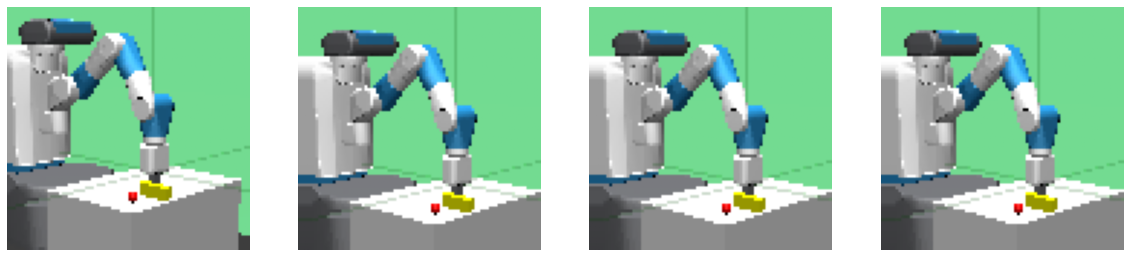

In [86]:
obs = env.reset()
num_images = 4
fig = plt.figure(figsize=(num_images*5, 5))
img = torch.FloatTensor(obs['image'])
aug = aug_trans(img)[0]
ax = plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(img[:3].numpy().transpose(1, 2, 0) / 255)
for i in range(3):
    ax = plt.subplot(1, 4, i + 2)
    plt.axis('off')
    plt.imshow(aug[3*i:3*(i+1)].numpy().transpose(1, 2, 0) / 255)